# 運動方程式の導出
(https://qiita.com/acela86/items/170dba21021e387dfc89)
* m1 : 台車の質量 [kg]
* m2 : 振子の質量 [kg]
* l : 振子の長さ [m]
* g : 重力加速度 [m/s^2]
* p : 台車中心の位置 [m]
* θ : 振子の角度 [rad]
* F : 台車への外力 [N]
* (x1,y1) : 台車の位置座標 [m]
* (x2,y2) : 振子の位置座標 [m]

## 手順（後ろからやる）
1. Lを作る。LにはN,Pa1,Pa2が必要
    1. Pa1に必要なPo1,m1
    1. Pa2に必要なPo2,m2
2. LにはPo1.set_velが必要
    1. vx1にはx1が必要
    1. vy1にはy1が必要
3. LMを作る。LMにはqs,forcelistが必要
    1. qsを*束縛条件が含まれるように上手に*作る
    1. いま作ったqsで2.をコーディングし直す
4. LMのメソッドで運動方程式を導出

In [1]:
import sympy as sy
import sympy.physics.mechanics as me

In [47]:
N = me.ReferenceFrame('N')
t = sy.symbols('t')

In [40]:
# 一般化座標
## 同時に束縛条件が組み込まれる一般化座標がいい
p, theta = me.dynamicsymbols("p theta")
qs = sy.Matrix([p,theta])

In [23]:
# 台車について
Po1 = me.Point("Po1")
m1 = sy.symbols("m1")
Pa1 = me.Particle("Pa1", Po1,m1)

In [51]:
x1 = p
vx1 = sy.diff(x1, t)
y1 = 0
vy1 = sy.diff(y1, t)
Po1.set_vel(N,vx1*N.x+vy1*N.y)

In [13]:
# 振り子先の質点について
Po2 = me.Point("Po2")
m2 = sy.Symbol("m2")
Pa2 = me.Particle("Pa2", Po2,m2)

In [49]:
l = sy.symbols('l') #振り子の棒の長さ
x2 = p - l*sy.sin(theta)
vx2 = sy.diff(x2, t)
y2 = 0 + l*sy.cos(theta)
vy2 = sy.diff(y2, t)
Po2.set_vel(N,vx2*N.x+vy2*N.y)

In [52]:
# ラグラジアンを作る
L = me.Lagrangian(N, Pa1,Pa2)

In [63]:
# forcelist
F = me.dynamicsymbols('F')
g = sy.symbols('g')
forcelist = [[Po1,F*N.x-m1*g*N.y], [Po2,-m2*g*N.y]]

In [57]:
LM = me.LagrangesMethod(L, qs=qs, forcelist=forcelist, frame=N)

In [61]:
# 運動方程式
eom = sy.simplify(LM.form_lagranges_equations())
eom

Matrix([
[m1*Derivative(p(t), (t, 2)) + m2*(l*sin(theta(t))*Derivative(theta(t), t)**2 - l*cos(theta(t))*Derivative(theta(t), (t, 2)) + Derivative(p(t), (t, 2))) - F(t)],
[                                                             l*m2*(-g*sin(theta(t)) + l*Derivative(theta(t), (t, 2)) - cos(theta(t))*Derivative(p(t), (t, 2)))]])

In [65]:
# 状態方程式
f = sy.simplify(LM.rhs())

$x=\left[\begin{array}{c}p\\ \theta\\ \dot{p} \\\dot{\theta}\end{array}\right]$、$u=F$として、
$$f(x,u)=\left[\begin{matrix}\frac{d}{d t} p{\left(t \right)}\\\frac{d}{d t} \theta{\left(t \right)}\\\frac{\frac{g m_{2} \sin{\left(2 \theta{\left(t \right)} \right)}}{2} - l m_{2} \sin{\left(\theta{\left(t \right)} \right)} \left(\frac{d}{d t} \theta{\left(t \right)}\right)^{2} + F{\left(t \right)}}{m_{1} + m_{2} \sin^{2}{\left(\theta{\left(t \right)} \right)}}\\\frac{g \left(m_{1} + m_{2}\right) \sin{\left(\theta{\left(t \right)} \right)} - \left(l m_{2} \sin{\left(\theta{\left(t \right)} \right)} \left(\frac{d}{d t} \theta{\left(t \right)}\right)^{2} - F{\left(t \right)}\right) \cos{\left(\theta{\left(t \right)} \right)}}{l \left(m_{1} + m_{2} \sin^{2}{\left(\theta{\left(t \right)} \right)}\right)}\end{matrix}\right]$$
これらで状態方程式$$\dot{x}=f(x,u)$$が記述される

In [94]:
# 非線形は解きにくいので、しょうがなく線形化する
## 線形化する起点はop_point
linearizer = LM.to_linearizer(q_ind=qs, qd_ind=sy.diff(qs))
op_point = {p:0, theta:0, sy.diff(p,t):0, sy.diff(theta,t):0}
A,B = linearizer.linearize(op_point=op_point, A_and_B=True, simplify=True)

In [95]:
A

Matrix([
[0,                  0, 1, 0],
[0,                  0, 0, 1],
[0,            g*m2/m1, 0, 0],
[0, g*(m1 + m2)/(l*m1), 0, 0]])

In [96]:
B

Matrix([
[       0],
[       0],
[    1/m1],
[1/(l*m1)]])

In [113]:
linearizer.q_i

Matrix([
[    p(t)],
[theta(t)]])

In [110]:
linearizer.r

Matrix([[F(t)]])

# $\theta$(t)=0を目指して状態フィードバック
## 極配置法
$x=\left[\begin{array}{c}p\\ \theta\\ \dot{p} \\\dot{\theta}\end{array}\right]$、$u=F$で、
$$\dot{x}(t)=Ax(t)+Bu(t)$$
$$y(t)=\left[\begin{array}{c}p\\ \theta\end{array}\right]$$
$u(t)=-Kx(t)$とすると、$$\dot{x}(t)=(A-BK)x(t)$$

In [297]:
import control.matlab as cm
A = A.subs([(g,9.80665),(m1,1.0),(m2,0.1),(l,0.8)])
B = B.subs([(m1,1.0),(l,0.8)])
C = np.eye(4)
D = [[0],[0],[0],[0]]
G = cm.ss(A,B,C,D)

#アッカーマンの極配置アルゴリズムを利用
Pole = [-1,-1,-1,-1] #所望の極配置を指定
K = cm.acker(G.A, G.B, Pole)
print(np.linalg.eigvals(G.A - G.B*K)) #できてるか確認

[-1.00020006+0.00020008j -1.00020006-0.00020008j -0.99979994+0.00020003j
 -0.99979994-0.00020003j]


<IPython.core.display.Javascript object>


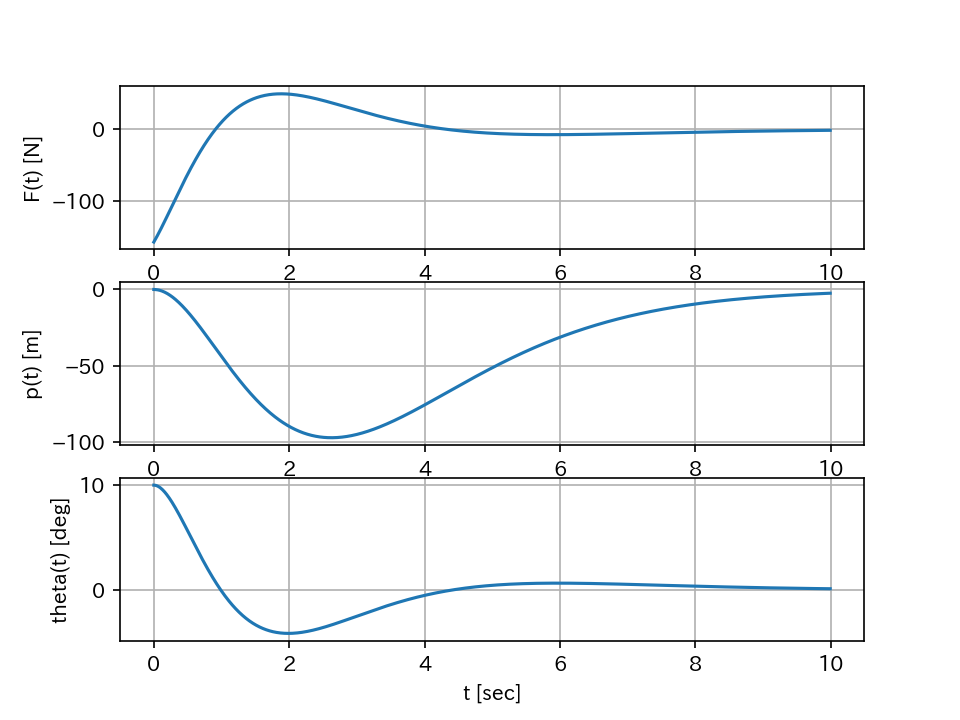

In [298]:
# うまく制御できているか確かめる。
# theta(0)=10 [deg]として
Gfb = cm.ss(G.A - G.B*K, G.B,G.C,G.D)
Td = np.arange(0,10, 0.01)
X0 = [0,10,0,0]
y, t = cm.initial(Gfb, Td,X0)

import matplotlib.pyplot as plt
fig,ax = plt.subplots(3)
ax[0].plot(t,-y*K.T, label="F(t)")
ax[1].plot(t,y[:,0], label="p(t)")
ax[2].plot(t,y[:,1], label="theta(t)")
ax[2].set_xlabel("t [sec]")
ax[0].set_ylabel("F(t) [N]")
ax[1].set_ylabel("p(t) [m]")
ax[2].set_ylabel("theta(t) [deg]")
ax[0].grid()
ax[1].grid()
ax[2].grid()
plt.show()

In [311]:
#i =200
#fig, ax = plt.subplots()

def update_fig(i):
    #アニメをかくための関数
    
    plt.cla()

    cart_x = 1.0
    cart_y = 0.4
    radius = 0.1
    bar = 0.8

    # cart
    ## 本体
    ax.plot([y[i,0]-cart_x/2,y[i,0]+cart_x/2], [0,0], "-b")
    ax.plot([y[i,0]-cart_x/2,y[i,0]+cart_x/2], [-cart_y,-cart_y], "-b")
    ax.plot([y[i,0]-cart_x/2,y[i,0]-cart_x/2], [0,-cart_y], "-b")
    ax.plot([y[i,0]+cart_x/2,y[i,0]+cart_x/2], [0,-cart_y], "-b")
    ## 車輪
    angle = np.arange(0,360)/180*np.pi #[rad]
    circle_x = radius*np.cos(angle)
    circle_y = radius*np.sin(angle)
    ax.plot(y[i,0]+circle_x-2*radius, 0-cart_y+circle_y-radius, "-k")
    ax.plot(y[i,0]+circle_x+2*radius, 0-cart_y+circle_y-radius, "-k")

    # 振り子
    ## 棒
    ax.plot([y[i,0],y[i,0]-bar*np.sin(y[i,1]/180*np.pi)],[0,bar*np.cos(y[i,1]/180*np.pi)], "-k")
    ## たま
    ax.plot(circle_x + y[i,0]-bar*np.sin(y[i,1]/180*np.pi), circle_y + bar*np.cos(y[i,1]/180*np.pi), "-k")

    #ax.set_xlim(min(y[:,0])-cart_x,max(y[:,1])+cart_x) ここはどうしたらいいかわからん
    ax.axis = "equal"

#plt.show()

In [288]:
%matplotlib notebook
from matplotlib import animation
fig, ax = plt.subplots()
anim = animation.FuncAnimation(fig, update_fig, frames=len(y), interval=10)
plt.show()

<IPython.core.display.Javascript object>

## 最適レギュレータ
評価関数を設定して、その値を最小化するフィードバックゲインを求める

$u$は$u=-Kx$とする。

評価関数$$J=\int_0^\infty[\vec{x}^T(t)\mathbf{Q}\vec{x}(t)+\vec{u}^T(t)\mathbf{R}\vec{u}(t)]dt$$を最小にする$\mathbf{K}$
を求める。なお、$\mathbf{Q}$、$\mathbf{R}$はテキトーな定数行列。

Jを最小にするのは$K_{opt}=R^{-1}B^TP$である。$P$は$$PA+A^TP-PBR^{-1}B^TP+Q=0$$を満たす

In [295]:
Q =[[1,0,0,0],[0,100,0,0],[0,0,1,0],[0,0,0,10]]
R = [[1]]
import scipy
P = scipy.linalg.solve_continuous_are(G.A,G.B,Q,R)
K = scipy.linalg.inv(R).dot(B.T).dot(P)

In [299]:
print(np.linalg.eigvals(G.A - G.B*K)) #安定かどうか確認

[-1.00020006+0.00020008j -1.00020006-0.00020008j -0.99979994+0.00020003j
 -0.99979994-0.00020003j]


<IPython.core.display.Javascript object>


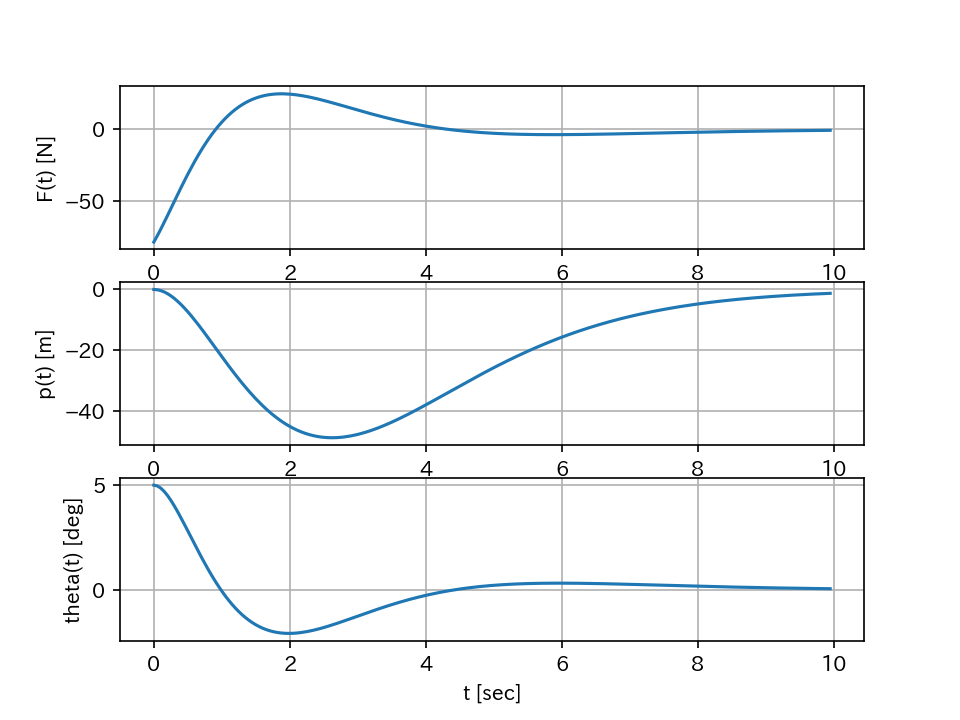

In [309]:
# うまく制御できているか確かめる。
# theta(0)=5 [deg]として
Gfb = cm.ss(G.A - G.B*K, G.B,G.C,G.D)
Td = np.arange(0,10, 0.05)
X0 = [0,5,0,0]
y, t = cm.initial(Gfb, Td,X0)

import matplotlib.pyplot as plt
fig,ax = plt.subplots(3)
ax[0].plot(t,-y*K.T, label="F(t)")
ax[1].plot(t,y[:,0], label="p(t)")
ax[2].plot(t,y[:,1], label="theta(t)")
ax[2].set_xlabel("t [sec]")
ax[0].set_ylabel("F(t) [N]")
ax[1].set_ylabel("p(t) [m]")
ax[2].set_ylabel("theta(t) [deg]")
ax[0].grid()
ax[1].grid()
ax[2].grid()
plt.show()

In [312]:
%matplotlib notebook
from matplotlib import animation
fig, ax = plt.subplots()
anim = animation.FuncAnimation(fig, update_fig, frames=len(y), interval=10)
plt.show()

<IPython.core.display.Javascript object>